# Predicting Boston Housing Prices through Regression

## Load dataset

In [6]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =\
    boston_housing.load_data()

## Normalize data

In [7]:
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## Build network

In [8]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
        input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## K-fold Validation

In [29]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 80
all_scores = []
all_mae_histories = []

In [31]:
for i in range(k):
    print('processing fold #', i)

    # prepare validation data from partition #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples:(i + 1) * num_val_samples]

    # prepare training data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # build and train model
    model = build_model()
    history = model.fit(
        partial_train_data, partial_train_targets, 
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=1, verbose=0)
    
    # save per-epoch validation scores
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


## Build and plot validation history

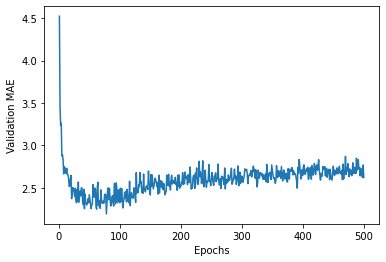

In [22]:
# build
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

# plot
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

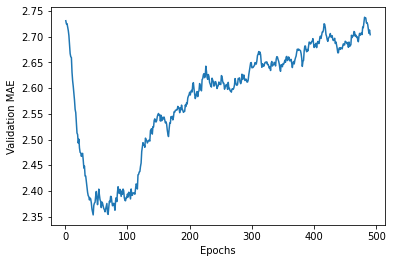

In [28]:
# plot smoothed scores

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.clf()
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## Train final model on all data

In [32]:
model = build_model()
model.fit(train_data, train_targets,
    epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 866us/step - loss: 23.1752 - mae: 2.9372


In [33]:
test_mae_score

2.9372193813323975